In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# from model import MSResNet

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
shot_types = 9
other_metrics = 1
total_metics = 10

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [6]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [7]:
def plot_swing(swing_data, shot_type=None, dist=None):
    """
    swing_data: Dx6 array of IMU data
    """
    
    columns = ["Ax", "Ay", "Az", "Gx", "Gy", "Gz"]
    plt.figure(figsize=(15,7))
    for idx, line in enumerate(swing_data):
        plt.subplot(2,3,idx+1)
        plt.title(columns[idx])
        plt.plot(line)
    if shot_type is not None:
        plt.suptitle(f"{shot_type}, {dist}yds")

In [8]:
X_data = []
y_data = [] 
# for i in range(100):
for csv in glob.glob(path + "*.csv"):
    x = pd.read_csv(csv).drop(columns="Unnamed: 0")
    y = np.zeros(total_metics)
    y[x["shot_type"][0]] = 1
    y[-1] = x["distance"][0]
    x_values = x.values[:, :-2].T
    X_data.append(x_values)
    y_data.append(y)
        
X_data = np.array(X_data)
y_data = np.array(y_data)

In [9]:
def plot_counts(y):
    pd.Series(np.argmax(y[:, :-1],axis=1)).value_counts(sort=False).plot.bar().set(ylabel="Count")

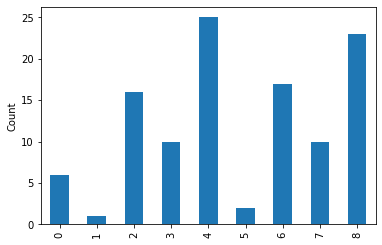

In [10]:
plot_counts(y_data)

In [11]:
len(glob.glob(path + "*.csv"))

110

In [12]:
# n=0
# for x, y in zip(X_data, y_data):
#     print(glob.glob(path + "*.csv")[n] + " " + str(n))
#     stype = np.argmax
#     plot_swing(x, shot_types[np.argmax(y[:-1])], int(y[-1]))
#     plt.show()
#     n+=1

In [13]:
n = X_data.shape[0]

# GENERATE DATA SPLITS
train = 0.75
val = 0.2
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*test):,:,:]
y_test = y_data[-int(n*test):,:]

# /GENERATE DATA SPLITS

In [14]:
X_train.shape, X_val.shape, X_test.shape

((82, 6, 500), (22, 6, 500), (5, 6, 500))

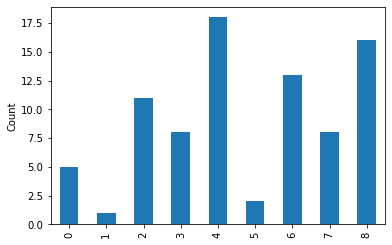

In [15]:
plot_counts(y_train)

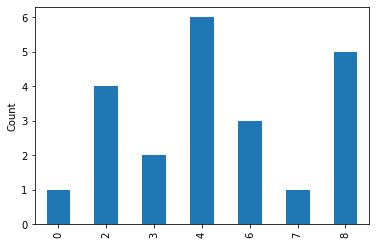

In [16]:
plot_counts(y_val)

In [17]:
def norm(x, m, s):
    return (x - m) / s

In [18]:
def augment(X):
    return torch.roll(X * np.random.uniform(low=0.8, high=1.1), np.random.randint(-150,150))

In [19]:
class SwingDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data, mean=None, std=None, y_mean=None, y_std=None, augment=False):
        super().__init__()
        self.X_data = torch.Tensor(X_data)
        self.y_data = torch.Tensor(y_data)
        self.augment = augment
        
        
        if mean is None: # assume that all the other values are None as well, this is the training set and we need to compute the mean/std
            self.mean = X_data.mean(axis=0)
            self.std = X_data.std(axis=0)
            self.y_dist_mean = y_data[:, -1].mean()
            self.y_dist_std = y_data[:, -1].std()
        else:
            self.mean = mean
            self.std = std
            self.y_dist_mean = y_mean
            self.y_dist_std = y_std
        
    def __len__(self):
        return self.X_data.shape[0]
    
    def __getitem__(self, idx):
        X = self.X_data[idx].clone()  # clone or else the normalization overwrites the actual tensor
        y = self.y_data[idx].clone()
        
        if self.augment:
            X = augment(X)
        
        X = norm(X, self.mean, self.std)
        y[-1] = norm(y[-1], self.y_dist_mean, self.y_dist_std) 
        
        return X, y 

In [20]:
train_set = SwingDataset(X_train, y_train, augment=True)
val_set = SwingDataset(X_val, y_val, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)
test_set = SwingDataset(X_test, y_test, mean=train_set.mean, std=train_set.std, y_mean=train_set.y_dist_mean, y_std=train_set.y_dist_std)

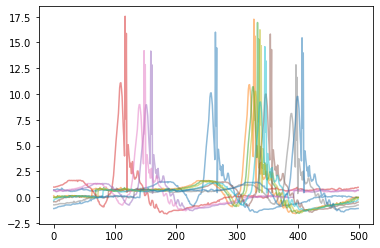

In [21]:
# test the data augmentation
plt.plot(train_set.X_data[0][0],alpha=0.5)
for _ in range(10):
    plt.plot(augment(train_set.X_data[0][0]), alpha=0.5)
plt.show()

In [23]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False, shuffle=True)

In [24]:
class BadModel(nn.Module):

    def __init__(self, num_conv_outer, num_conv_inner, ksize, 
                 num_hidden=1, num_unit=100, nchannel_base=6, num_class=10):
        super(BadModel, self).__init__()
        
        # 6 dims from ax,ay,az,gx,gy,gz
        indim = 6
        
        # TODO: Set this to whatever the truncated input length is
        # or better yet, determine it dynamically 
        cur_w = 500
        
        self.num_hidden = num_hidden
        self.num_conv_outer = num_conv_outer
        self.num_conv_inner = num_conv_inner
        
        outdim = None
        for _i in range(num_conv_outer):
            outdim = nchannel_base * 2 ** _i
            for _j in range(num_conv_inner):
                setattr(self, f"conv_conv1d_{_i}_{_j}", nn.Conv1d(indim, outdim, ksize))
                setattr(self, f"conv_relu_{_i}_{_j}", nn.ReLU())
                cur_w = (cur_w - ksize) + 1
                indim = outdim

            setattr(self, f"conv_pool_{_i}", nn.MaxPool1d(2, 2))
            cur_w = (cur_w - 2) // 2 + 1

        indim = outdim * cur_w
        for _i in range(num_hidden):
            outdim = num_unit
            setattr(self, f"fc_linear_{_i}", nn.Linear(indim, outdim))
            setattr(self, f"fc_relu_{_i}", nn.ReLU())
            indim = outdim
            
        self.output = nn.Linear(indim, num_class)
        self.softmax = nn.Softmax(dim=1)

#         print(self)
        
    def forward(self, x):
        for _i in range(self.num_conv_outer):
            for _j in range(self.num_conv_inner):
                x = getattr(self, f"conv_conv1d_{_i}_{_j}")(x)
                x = getattr(self, f"conv_relu_{_i}_{_j}")(x)
            x = getattr(self, f"conv_pool_{_i}")(x)

        # Flatten
        x = x.view(x.shape[0], -1)
        
        # Apply the fully connected layers
        for _i in range(self.num_hidden):
            x = getattr(self, "fc_linear_{}".format(_i))(x)
            x = getattr(self, "fc_relu_{}".format(_i))(x)
        x = self.output(x)

        # softmax on the swing type classes
        swing_type = self.softmax(x[:,:-1])
        
        # concatenate back with the distance regression
        x = torch.cat([swing_type, x[:,-1:]], axis=1)
        
        return x

In [25]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel(5, 1, 3).to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

In [60]:
loss_history = []
epochs = 100
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
#     for data in tqdm(train_loader, desc=prefix):
    for data in train_loader:
        print(e, end="\r", flush=True)
        iter_idx += 1
        X_train, y = data
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_train.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

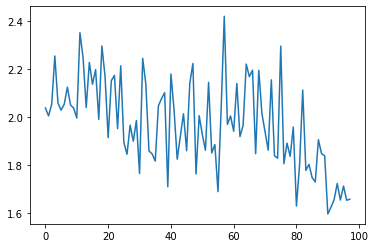

In [71]:
plt.plot(va_losses)

In [62]:
def print_preds(predicitons, truth, mean, std):
    for pred, true in zip(predicitons, truth):
        pred_distance = pred[-1] * std + mean
        pred_argmax = torch.argmax(pred[:-1])
        pred_shot_type = shot_types[pred_argmax]
        print(f"Pred: {pred_shot_type} {round(pred_distance.item())}yds")
        
        true_distance = true[-1] * std + mean
        true_argmax = torch.argmax(true[:-1])
        true_shot_type = shot_types[true_argmax]
        
        print(f"True: {true_shot_type} {round(true_distance.item())}yds")
        print()

In [63]:
print_preds(outputs, y, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Fade 139yds
True: Straight 115yds

Pred: Push-slice 72yds
True: Pull-hook 70yds



In [64]:
print_preds(outputs_va, y_va, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Straight 125yds
True: Pull 145yds

Pred: Straight 113yds
True: Push-slice 70yds



# Test

In [65]:
# normalization moved to the dataloader
# X_test_norm = norm(X_test, train_mean, train_std)
# y_test_norm = y_test.copy()
# y_test_norm[:, -1] -= y_distance_mean
# y_test_norm[:, -1] /= y_distance_std

test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, drop_last=False)

In [66]:
swing_losses, dist_losses, total_losses, = [], [], []
model = model.eval()
idx = 0

test_out = []
true_out = []
test_shot_types = []
true_shot_types = []

with torch.no_grad():
    for data in test_loader:
        idx += 1
        x_test, y_test = data
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        outputs = model(x_test.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y_test[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y_test[:, -1:])
        total_loss = swing_loss + dist_loss
        
        swing_losses += [swing_loss.cpu().numpy()]
        dist_losses += [dist_loss.cpu().numpy()]
        total_losses += [total_loss.cpu().numpy()]
        
        print("Test example %d: swing_loss = %f, dist_loss = %f" % (idx, swing_losses[idx-1], dist_losses[idx-1]), end="\r", flush=True)
  
        test_out.append(outputs[0])
        true_out.append(y_test[0])
        test_shot_types.append(np.argmax(outputs[:, :-1]).item())
        true_shot_types.append(np.argmax(y_test[:, :-1]).item())
#         test_shot_dist.append(outputs[:,0].item())
#         true_shot_dist.append(y_test[:,0].item())
    
    avg_swing_loss = np.mean(swing_losses)
    avg_dist_loss = np.mean(dist_losses)
    avg_total_loss = np.mean(total_losses)
    print()
    print("Out of %d test examples: avg_swing_loss = %f, avg_dist_loss = %f, avg_total_loss = %f" % (idx, avg_swing_loss, avg_dist_loss, avg_total_loss))

Test example 5: swing_loss = 0.241156, dist_loss = 0.187903
Out of 5 test examples: avg_swing_loss = 0.309485, avg_dist_loss = 0.627218, avg_total_loss = 0.936704


In [67]:
print_preds(test_out, true_out, train_set.y_dist_mean, train_set.y_dist_std)

Pred: Straight 126yds
True: Slice 125yds

Pred: Straight 114yds
True: Push 145yds

Pred: Straight 118yds
True: Push-slice 70yds

Pred: Straight 123yds
True: Pull 145yds

Pred: Straight 124yds
True: Straight 140yds



In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [69]:
cm = confusion_matrix(true_shot_types, test_shot_types)

<AxesSubplot:>

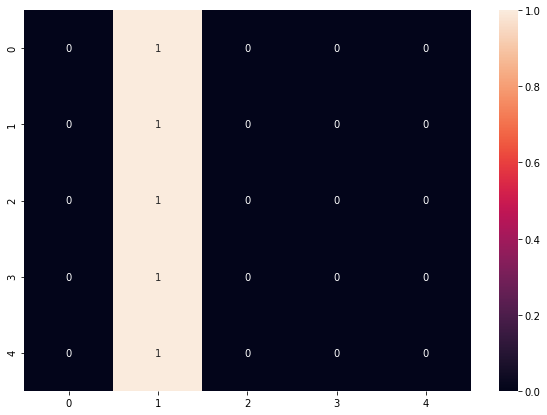

In [70]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)